## 基本要求
a) 采用分层采样的方式将数据集划分为训练集和测试集。  
b) 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

In [18]:
import math
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import random

In [19]:
f = open('wine.data','r')
types = [[],[],[]]                      #按类分的所有数据
test_data = [[],[],[]]
train_data = [[],[],[]]
data_num = 0                            #数据总数
test_len = []                           #测试集里每一类的个数
mean = [[],[],[]]                       #每一类的均值
std = [[],[],[]]                        #每一类的标准差
myline = '1'
while myline:
    myline = f.readline().split(',')
    if len(myline) != 14:
        break
    for t in range(len(myline)):
        if t == 0:
            myline[t] = int(myline[t])
        else:
            myline[t] = float(myline[t])
    temp = myline.pop(0)
    types[temp - 1].append(myline)
test_len = [round(len(types[i]) / 4) for i in range(3)]
data_num = sum([len(types[i]) for i in range(3)])
test_len

[15, 18, 12]

### 分层采样

In [20]:
random.shuffle(types[0])
random.shuffle(types[1])
random.shuffle(types[2])
for i in range(58):
    if(i < test_len[0]):
        test_data[0].append(types[0][i])
    else:
        train_data[0].append(types[0][i])
for i in range(70):
    if (i < test_len[1]):
        test_data[1].append(types[1][i])
    else:
        train_data[1].append(types[1][i])
for i in range(47):
    if(i < test_len[2]):
        test_data[2].append(types[2][i])
    else:
        train_data[2].append(types[2][i])

In [21]:
p = [(59-test_len[0])/data_num, (71-test_len[1])/data_num, (48-test_len[2])/data_num]
w1_train = np.array(train_data[0])
w2_train = np.array(train_data[1])
w3_train = np.array(train_data[2])

In [22]:
def Gauss_p(x, mean, std):
    tmp = 1 / (2 * math.pi * std)
    tmp1 = (x - mean)**2 / (2 * std**2)
    return tmp * np.exp(-tmp1)

In [23]:
def bayes_classificate():
    mean[0] = np.mean(w1_train, axis=0)
    std[0] = np.std(w1_train, axis=0)
    mean[1] = np.mean(w2_train, axis=0)
    std[1] = np.std(w2_train, axis=0)
    mean[2] = np.mean(w3_train, axis=0)
    std[2] = np.std(w3_train, axis=0)
    wrong_num = 0
    for i in range(3):
        for t in test_data[i]:  # 两层循环：从每一类取每一个测试样本
            my_type = []
            for j in range(3):
                tmp = p[j]
                for d in range(13):
                    tmp *= Gauss_p(t[d], mean[j][d], std[j][d])
                my_type.append(tmp)  # 这里将所有score保存
            pre_type = my_type.index(max(my_type))  # 取分值最大的为预测类别
            if pre_type != i:  # 统计错误数
                wrong_num += 1
    return wrong_num

In [24]:
print("共测试{0}个样本，错误个数为{1}个，准确率为:{2}".format(np.sum(test_len), bayes_classificate(), 1-(bayes_classificate()/np.sum(test_len))))

共测试45个样本，错误个数为1个，准确率为:0.9777777777777777


因为测试样本少，故准确率有较大浮动

## 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

In [25]:
def get_Confusion_Matrix():
    ConMat = [[0,0,0],
              [0,0,0],
              [0,0,0]]
    for i in range(3):
        for t in test_data[i]:  # 两层循环：从每一类取每一个测试样本
            my_type = []
            for j in range(3):
                tmp = p[j]
                for d in range(13):
                    tmp *= Gauss_p(t[d], mean[j][d], std[j][d])
                my_type.append(tmp)  # 这里将所有score保存
            pre_type = my_type.index(max(my_type))  # 取分值最大的为预测类别
            ConMat[i][pre_type] = ConMat[i][pre_type] + 1
    return ConMat

In [26]:
ConMat = get_Confusion_Matrix()
tp = [0,0,0]
fn = [0,0,0]
fp = [0,0,0]
tn = [0,0,0]
for i in range(3):
    for j in range(3):
        if(i == j):
            tp[i] =  ConMat[i][j]
        else:
            fp[i] = fp[i] + ConMat[i][j]
    fn[i] = np.sum(ConMat, axis=0)[i] - tp[i]
    tn[i] = np.sum(test_len) - (tp[i]+fp[i]+fn[i])

In [27]:
tp,fn,fp,tn

([14, 18, 12], [0, 1, 0], [1, 0, 0], [30, 26, 33])

In [28]:
precision = []
recall = []
f_measure = []
for i in range(3):
    precision.append(tp[i]/(tp[i]+fp[i]))
    recall.append(tp[i]/(tp[i]+fn[i]))
    f_measure.append(2/(1/precision[i]+1/recall[i]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-Measure: " + str(f_measure))

Precision: [0.9333333333333333, 1.0, 1.0]
Recall: [1.0, 0.9473684210526315, 1.0]
F-Measure: [0.9655172413793105, 0.972972972972973, 1.0]


## 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

In [29]:
score = [[],[],[]]
for k in range(3):
    for i in range(3):
        for j in test_data[i]:
            tmp = []
            tmp.append(i + 1)
            tmp.append(p[i])
            for d in range(13):
                tmp[1] *= Gauss_p(j[d], mean[k][d], std[k][d])
            score[k].append(tmp)
    score[k] = np.array(score[k])
    score[k] = score[k][np.lexsort(-score[k].T)]

In [30]:
x = [[],[],[]]
y = [[],[],[]]
a = np.zeros((3,45,2))
for i in range(3):
    tmp_x = 0
    tmp_y = 0
    k = 0
    p = 1/(tp[i]+fp[i])
    n = 1/(tn[i]+fn[i])
    for j in score[i]:
        if(j[0] == i+1):
            tmp_y = tmp_y + p
            a[i][k][0] = tmp_x
            a[i][k][1] = tmp_y
            k = k + 1
            x[i].append(tmp_x)
            y[i].append(tmp_y)
        else:
            tmp_x = tmp_x + n
            a[i][k][0] = tmp_x
            a[i][k][1] = tmp_y
            k = k + 1
            x[i].append(tmp_x)
            y[i].append(tmp_y)

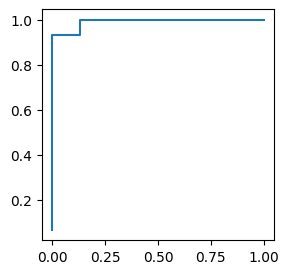

In [31]:
plt.figure(figsize=(3,3))
plt.plot(x[0],y[0])
plt.show()

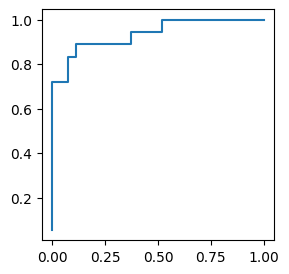

In [32]:
plt.figure(figsize=(3,3))
plt.plot(x[1],y[1])
plt.show()

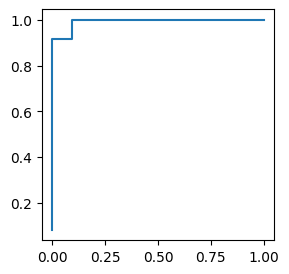

In [33]:
plt.figure(figsize=(3,3))
plt.plot(x[2],y[2])
plt.show()

In [34]:
auc = [0,0,0]
for i in range(3):
    n = (tn[i]+fn[i])
    for j in range(a.shape[1] - 1):
        if(a[i][j][0] != a[i][j + 1][0]):
            auc[i] = auc[i] + a[i][j + 1][1]
    auc[i] = auc[i]/n
auc

[0.991111111111111, 0.9362139917695474, 0.9924242424242424]